###Problem Statement


General-purpose Large Language Models (LLMs) often lack localized cultural and linguistic depth regarding Indian Sign Language (ISL). They frequently propagate myths—such as the idea that sign language is a hand-representation of spoken language or that it was invented by hearing people. This project implements a Retrieval-Augmented Generation (RAG) system to provide factually grounded answers about ISL. By anchoring the model in official educational text, we eliminate hallucinations and ensure users receive accurate information about the independent structure and natural evolution of ISL.

###Dataset / Knowledge Source


Type of Data: Digital PDF.

Data Source: Self-created/Curated technical notes on Indian Sign Language.

Content Characteristics: The dataset consists of 35 numbered factual anchors covering ISL grammar, regional variations, and its status as a "complete language".

### RAG Architecture

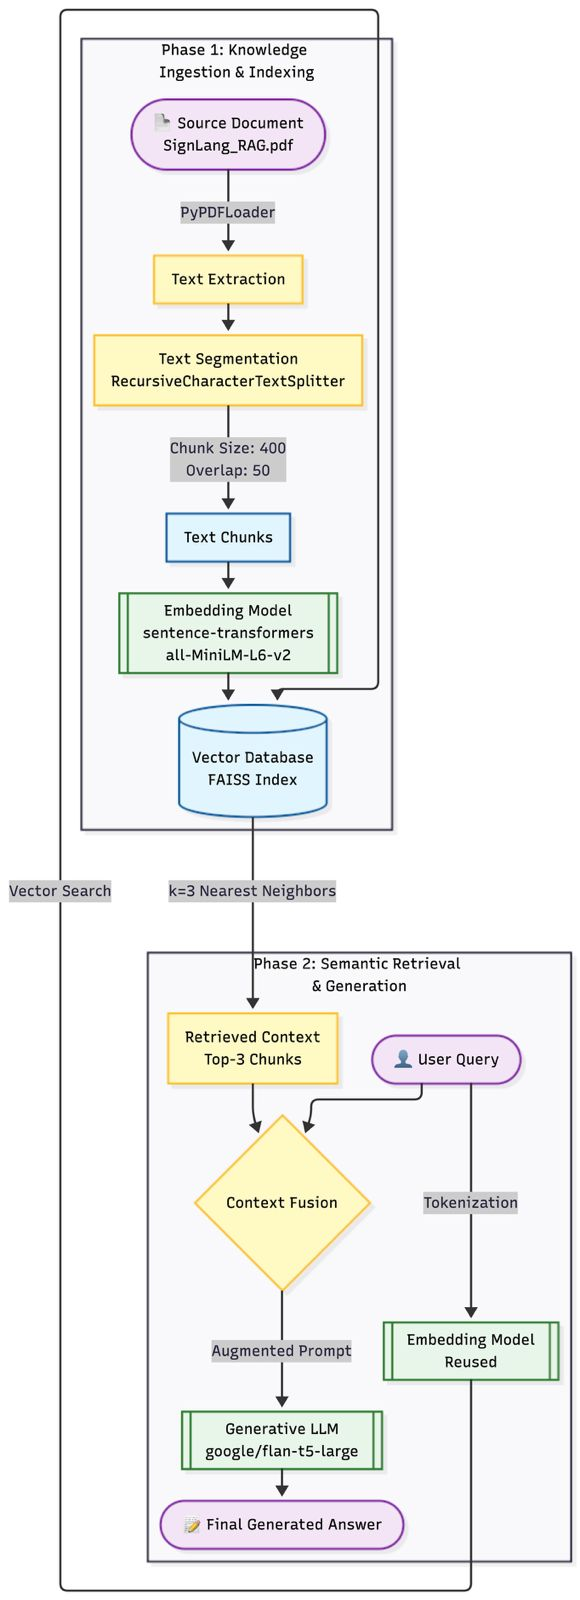

In [ ]:
import os

!pip install langchain
!pip install pypdf
!pip install langchain-community

from langchain_community.document_loaders import PyPDFLoader

file_path = "/content/SignLang_RAG.pdf"
loader = PyPDFLoader(file_path)

data = loader.load()

print(f"Successfully loaded {len(data)} pages from {file_path}")

Successfully loaded 2 pages from /content/SignLang_RAG.pdf


### Text Chunking Strategy


**Specifications:**
* **Chunk Size:** 400 Characters
* **Chunk Overlap:** 50 Characters (approx. 12% overlap)

**Why this Strategy? (Technical Reason):**
* **Precision:** The ISL document consists of short, numbered facts (e.g., "..."). A smaller chunk size (400) keeps these facts isolated. If we used a large size (like 1000), a single chunk might contain 3-4 unrelated topics, confusing the answer.
* **Context Safety:** The 50-character overlap ensures that if a sentence is cut in the middle, the full meaning is preserved in the next chunk.

In [ ]:
!pip install langchain
!pip install langchain-text-splitters

from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=50,
    length_function=len,
    separators=["\n\n", "\n", " ", ""]
)

chunks = text_splitter.split_documents(data)

print(f"Total Chunks: {len(chunks)}")
print(f"Content of Chunk 1: {chunks[0].page_content}")

Total Chunks: 9
Content of Chunk 1: Each country or region has its own sign language, with its own vocabulary 
and grammar. Deaf people from different countries cannot easily understand 
each other’s sign language. If a hearing person learns sign language in one 
country, the person cannot easily understand a sign language from another 
country, but has to learn the other sign language separately. Even within one


### 4. Embedding Details & Vector Database

**Embedding Model Used:** `sentence-transformers/all-MiniLM-L6-v2`

**Reason for Selection:**
* **Efficiency:** This model is optimized for local CPU execution, making it perfect for the Google Colab environment without requiring external API keys.
* **Performance:** It maps sentences to a 384-dimensional dense vector space and is specifically trained for semantic similarity tasks, ensuring high accuracy for retrieval.

In [ ]:
!pip install langchain-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 39.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.4.0
    Uninstalling huggingface_hub-1.4.0:
      Successfully uninstalled huggingface_hub-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 5.0.0 requires huggingface-hub<2.0,>=1.3.0, but you have huggingface-hub 0.36.2 which is incompatible.


In [ ]:
!pip install sentence-transformers

from langchain_huggingface import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

print("Embedding Model Loaded Successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.3/553.3 kB 43.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 0.36.2
    Uninstalling huggingface_hub-0.36.2:
      Successfully uninstalled huggingface_hub-0.36.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-huggingface 1.2.0 requires huggingface-hub<1.0.0,>=0.33.4, but you have huggingface-hub 1.4.1 which is incompatible.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding Model Loaded Successfully.


### 5. Vector Database

**Vector Store Used:** FAISS (Facebook AI Similarity Search)

**Reason for Selection:**
* **Speed:** FAISS is highly optimized for dense vector similarity search, making it faster than standard list comparisons.
* **Local Implementation:** unlike ChromaDB or Pinecone which can require server setups, FAISS works perfectly in-memory for this notebook environment.

In [ ]:
!pip install faiss-cpu

from langchain_community.vectorstores import FAISS

vector_db = FAISS.from_documents(chunks, embedding_model)

print("Vector Database Created Successfully.")
print(f"Total Vectors Stored: {vector_db.index.ntotal}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 83.7 MB/s eta 0:00:00
Vector Database Created Successfully.
Total Vectors Stored: 9


### 6. RAG Pipeline (Retrieval + Generation)

**Implementation Details:**
* **Retriever:** We convert our Vector Database into a retriever object that fetches the top 3 most relevant chunks for every query.
* **LLM (Generator):** We use `google/flan-t5-large`. This is a sequence-to-sequence model optimized for various NLP tasks, including answering questions based on context.
* **Chain:** We use LangChain's `RetrievalQA` chain to connect the Retriever and the LLM.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from langchain_huggingface import HuggingFacePipeline
from langchain_classic.chains import RetrievalQA

print("Initializing RAG Pipeline...")


model_id = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)


pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    temperature=0.1,
    repetition_penalty=1.1,
    device=0 if torch.cuda.is_available() else -1
)

local_llm = HuggingFacePipeline(pipeline=pipe)


retriever = vector_db.as_retriever(search_kwargs={"k": 3})


qa_chain = RetrievalQA.from_chain_type(
    llm=local_llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)

print("RAG Pipeline is fully initialized and ready to answer questions!")

Initializing RAG Pipeline...


Loading weights:   0%|          | 0/558 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
Passing `generation_config` together with generation-related arguments=({'temperature', 'max_length', 'repetition_penalty'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'AfmoeForCausalLM', 'ApertusForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'BltFo

RAG Pipeline is fully initialized and ready to answer questions!


### 7. Testing & Evaluation

**Test Strategy:**
We test the system with 3 distinct types of queries to validate performance:
1.  **Factual Query:** To test direct retrieval accuracy.
2.  **Conceptual Query:** To test the model's ability to synthesize information.
3.  **Correction Query:** To see if the model can debunk misconceptions using the text (e.g., "Was ISL invented by hearing people?").

In [ ]:
test_queries = [
    "Is Indian Sign Language similar to Hindi?",
    "Who invented sign language?",
    "Can a deaf person from India understand American Sign Language?"
]

for query in test_queries:
    print(f"\nQuery: {query}")
    print("-" * 30)

    # Get answer from chain
    answer = qa_chain.invoke(query)
    print(f"Answer: {answer}")

    # Get source documents separately
    source_docs = retriever.invoke(query)

    print("\nSources Used:")
    for i, doc in enumerate(source_docs[:3]):
        print(f"\nSource {i+1}:")
        print(doc.page_content)

    print("=" * 50)


Query: Is Indian Sign Language similar to Hindi?
------------------------------
Answer: {'query': 'Is Indian Sign Language similar to Hindi?', 'result': "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\nThis is wrong! \nEach sign language in each country or region has its own structure. This \nstructure differs significantly from the structure of the spoken language used \nin the same country. Sign language is not dependent on spoken language in \nany way. Indian Sign Language (ISL) is not at all similar to Hindi, to English,\n\nLanguage, have more or better grammar and are more developed than \nIndian Sign Language. This is not correct. \n\x00 As Indian Sign Language expands to new professional contexts, its \nprofessional vocabulary also grows. The same process has happened in \nother sign languages. It is an automatic and natural process, and it does not \nmean that 